## Libraries

In [1]:
import os
import pickle

import pandas as pd
import seaborn as sns

import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

from src.data_preparation.data_preprocessing import DataPreparer, DataSplitter, DataScaler
from src.config import Config

# Data

In [2]:
config = Config()
df = pd.read_csv(config.reporting_data_file_name)
df

,country,year,population,gdp,temperature_change_from_co2,cement_co2,coal_co2,flaring_co2,gas_co2,land_use_change_co2,oil_co2,co2
0,Argentina,1928,11139114.0,7.716888e+10,0.004,0.116,8.284,0.000,0.297,228.958,4.041,241.697
1,Argentina,1929,11443159.0,8.069191e+10,0.004,0.174,8.321,0.000,0.458,229.748,4.177,242.878
2,Argentina,1930,11726853.0,7.735969e+10,0.004,0.189,8.119,0.000,0.454,181.910,4.005,194.678
3,Argentina,1931,11989069.0,7.199214e+10,0.004,0.265,6.947,0.000,0.564,150.371,5.067,163.215
4,Argentina,1932,12228636.0,6.962483e+10,0.004,0.247,6.331,0.000,0.769,132.840,5.752,145.940
...,...,...,...,...,...,...,...,...,...,...,...,...
3994,Vietnam,2018,94914328.0,6.815014e+11,0.005,49.637,122.121,1.373,18.554,247.029,66.036,504.751
3995,Vietnam,2019,95776712.0,7.316531e+11,0.006,56.538,191.443,1.453,18.906,248.054,73.449,589.843
3996,Vietnam,2020,96648680.0,7.526296e+11,0.006,60.066,215.817,1.257,16.931,249.736,69.272,613.079
3997,Vietnam,2021,97468024.0,7.719120e+11,0.006,62.071,211.893,0.995,13.757,252.922,63.838,605.475


In [3]:
# Add indexes
df[config.additional_index] = df["country"]
df = df.set_index([config.year_index, config.additional_index])
df

,,country,population,gdp,temperature_change_from_co2,cement_co2,coal_co2,flaring_co2,gas_co2,land_use_change_co2,oil_co2,co2
year,country_index,,,,,,,,,,,
1928,Argentina,Argentina,11139114.0,7.716888e+10,0.004,0.116,8.284,0.000,0.297,228.958,4.041,241.697
1929,Argentina,Argentina,11443159.0,8.069191e+10,0.004,0.174,8.321,0.000,0.458,229.748,4.177,242.878
1930,Argentina,Argentina,11726853.0,7.735969e+10,0.004,0.189,8.119,0.000,0.454,181.910,4.005,194.678
1931,Argentina,Argentina,11989069.0,7.199214e+10,0.004,0.265,6.947,0.000,0.564,150.371,5.067,163.215
1932,Argentina,Argentina,12228636.0,6.962483e+10,0.004,0.247,6.331,0.000,0.769,132.840,5.752,145.940
...,...,...,...,...,...,...,...,...,...,...,...,...
2018,Vietnam,Vietnam,94914328.0,6.815014e+11,0.005,49.637,122.121,1.373,18.554,247.029,66.036,504.751
2019,Vietnam,Vietnam,95776712.0,7.316531e+11,0.006,56.538,191.443,1.453,18.906,248.054,73.449,589.843
2020,Vietnam,Vietnam,96648680.0,7.526296e+11,0.006,60.066,215.817,1.257,16.931,249.736,69.272,613.079


## Partial Autocorrelation Function (PACF) correlogram - indicates which delays are most important when eliminating the influence of previous lags.

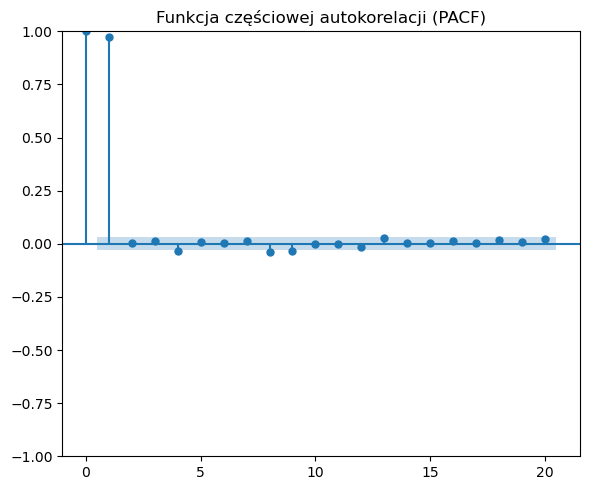

In [4]:
time_series = df['co2']

fig, ax = plt.subplots(figsize=(6, 5))
sm.graphics.tsa.plot_pacf(time_series, lags=20, ax=ax)

ax.set_title('Funkcja częściowej autokorelacji (PACF)') #Partial Autocorrelation Function
plt.tight_layout()
plt.show()

## Prepare 2 variants, general co2 values and co2 values per capita

In [5]:
data_preparer = DataPreparer()

In [6]:
#general co2 values
df

#co2 values per capita
df_per_capita = data_preparer.divide_by_population(df)

## Prepare data to has feature from = year-2 + year-1 and target = year

In [7]:
#ARIMAX
arimax_df = data_preparer.create_arimax_lightgbm_data(df, config.additional_index, num_lags = 2)
arimax_df_per_capita = data_preparer.create_arimax_lightgbm_data(df_per_capita, config.additional_index, num_lags = 2)

In [8]:
#LightGBM
lightgbm_df = data_preparer.create_arimax_lightgbm_data(df, config.additional_index, num_lags = 2)
lightgbm_df_per_capita = data_preparer.create_arimax_lightgbm_data(df_per_capita, config.additional_index, num_lags = 2)

In [9]:
#LSTM
lstm_df = data_preparer.create_lstm_data(df, config.year_index, config.additional_index)
lstm_df_per_capita = data_preparer.create_lstm_data(df_per_capita, config.year_index, config.additional_index)

### Correlation matrix (ARIMAX)

<Axes: >

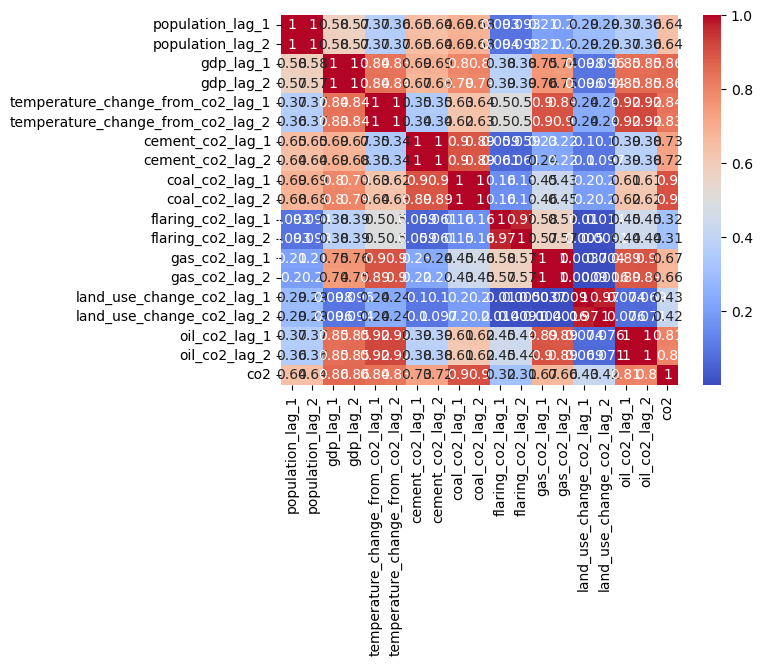

In [10]:
correlation_arimax_matrix = arimax_df.corr()
sns.heatmap(correlation_arimax_matrix, annot=True, cmap="coolwarm")

In [11]:
# Select only the independent variables (exogenous variables) for which you want to check multicollinearity
X = arimax_df.drop(columns=['co2'], inplace = False)  # Remove the target variable

# Add a constant (intercept) to the independent variables
X = sm.add_constant(X)

# Create a DataFrame to store the VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,Feature,VIF
0,const,0.000000
1,population_lag_1,37816.277622
2,population_lag_2,38211.856354
3,gdp_lag_1,2054.751524
4,gdp_lag_2,1990.218984
5,temperature_change_from_co2_lag_1,6376.613722
6,temperature_change_from_co2_lag_2,6207.802253
7,cement_co2_lag_1,479.437129
8,cement_co2_lag_2,469.390031
9,coal_co2_lag_1,380.184813


## Split to train and test data

In [12]:
data_splitter = DataSplitter()

In [13]:
#ARIMA
train_arimax_df, test_arimax_df = data_splitter.split_data(arimax_df, config.year_index, config.additional_index)
train_arimax_per_capita_df, test_arimax_per_capita_df = data_splitter.split_data(arimax_df_per_capita, config.year_index, config.additional_index)

In [14]:
#LightGBM
train_lightgbm_df, test_lightgbm_df = data_splitter.split_data(lightgbm_df, config.year_index, config.additional_index)
train_lightgbm_per_capita_df, test_lightgbm_per_capita_df = data_splitter.split_data(lightgbm_df_per_capita, config.year_index, config.additional_index)

In [15]:
#LSTM
train_lstm_df, test_lstm_df = data_splitter.split_data(lstm_df, config.year_index, config.additional_index)
train_lstm_per_capita_df, test_lstm_per_capita_df = data_splitter.split_data(lstm_df_per_capita, config.year_index, config.additional_index)

## Save ARIMAX data + preparing variant with exogenous and target variable for arimax using principal component analysis (PCA)

In [16]:
# Separate target (y) before PCA

# general co2
y_train_arimax = train_arimax_df['co2']
y_test_arimax = test_arimax_df['co2']

y_train_arimax.to_csv(os.path.join(config.output_cleaned_arimax, 'co2/y_train.csv'))
y_test_arimax.to_csv(os.path.join(config.output_cleaned_arimax, 'co2/y_test.csv'))

# co2 per capita
y_train_arimax_per_capita = train_arimax_per_capita_df['co2']
y_test_arimax_per_capita = test_arimax_per_capita_df['co2']

y_train_arimax_per_capita.to_csv(os.path.join(config.output_cleaned_arimax, 'co2_per_capita/y_train.csv'))
y_test_arimax_per_capita.to_csv(os.path.join(config.output_cleaned_arimax, 'co2_per_capita/y_test.csv'))

In [17]:
# All features, excluding the target

#general co2
exog_train_arimax = train_arimax_df.drop(columns=['co2'], inplace = False)
exog_test_arimax = test_arimax_df.drop(columns=['co2'], inplace = False)

exog_train_arimax.to_csv(os.path.join(config.output_cleaned_arimax, 'co2/exog_train.csv'))
exog_test_arimax.to_csv(os.path.join(config.output_cleaned_arimax, 'co2/exog_test.csv'))

#co2 per capita
exog_train_arimax_per_capita = train_arimax_per_capita_df.drop(columns=['co2'], inplace = False)
exog_test_arimax_per_capita = test_arimax_per_capita_df.drop(columns=['co2'], inplace = False)

exog_train_arimax_per_capita.to_csv(os.path.join(config.output_cleaned_arimax, 'co2_per_capita/exog_train.csv'))
exog_test_arimax_per_capita.to_csv(os.path.join(config.output_cleaned_arimax, 'co2_per_capita/exog_test.csv'))

In [18]:
# Features using PCA

#general co2
data_preprocessor_arimax = DataScaler()
exog_train_arimax_scaled, exog_test_arimax_scaled = data_preprocessor_arimax.preprocess_data(exog_train_arimax, exog_test_arimax)

with open(os.path.join(config.output_cleaned_arimax, 'co2/data_preprocessor_arimax.pkl'), 'wb') as f: # Save the DataScaler object after it has been fitted
    pickle.dump(data_preprocessor_arimax, f)

#co2 per capita
data_preprocessor_arimax_per_capita = DataScaler()
exog_train_arimax_per_capita_scaled, exog_test_arimax_per_capita_scaled = data_preprocessor_arimax_per_capita.preprocess_data(exog_train_arimax_per_capita, exog_test_arimax_per_capita)

with open(os.path.join(config.output_cleaned_arimax, 'co2_per_capita/data_preprocessor_arimax.pkl'), 'wb') as f: # Save the DataScaler object after it has been fitted
    pickle.dump(data_preprocessor_arimax_per_capita, f)


In [19]:
# Apply PCA to the scaled exogenous variables (training data)
pca = PCA(n_components=0.95)  # Keep components that explain 95% of the variance

#general co2
exog_train_arimax_pca = pca.fit_transform(exog_train_arimax_scaled)
exog_test_arimax_pca = pca.transform(exog_test_arimax_scaled)

num_components = exog_train_arimax_pca.shape[1]
component_names = [f"PC{i+1}" for i in range(num_components)]

exog_train_arimax_pca_df = pd.DataFrame(exog_train_arimax_pca, columns=component_names, index=exog_train_arimax.index)
exog_test_arimax_pca_df = pd.DataFrame(exog_test_arimax_pca, columns=component_names, index=exog_test_arimax.index)

exog_train_arimax_pca_df.to_csv(os.path.join(config.output_cleaned_arimax, 'co2/pca_train.csv'))
exog_test_arimax_pca_df.to_csv(os.path.join(config.output_cleaned_arimax, 'co2/pca_test.csv'))

#co2 per capita
exog_train_arimax_per_capita_pca = pca.fit_transform(exog_train_arimax_per_capita_scaled)
exog_test_arimax_per_capita_pca = pca.transform(exog_test_arimax_per_capita_scaled)

num_components = exog_train_arimax_per_capita_pca.shape[1]
component_names = [f"PC{i+1}" for i in range(num_components)]

exog_train_arimax_per_capita_pca_df = pd.DataFrame(exog_train_arimax_per_capita_pca, columns=component_names, index=exog_train_arimax_per_capita.index)
exog_test_arimax_per_capita_pca_df = pd.DataFrame(exog_test_arimax_per_capita_pca, columns=component_names, index=exog_test_arimax_per_capita.index)

exog_train_arimax_per_capita_pca_df.to_csv(os.path.join(config.output_cleaned_arimax, 'co2_per_capita/pca_train.csv'))
exog_test_arimax_per_capita_pca_df.to_csv(os.path.join(config.output_cleaned_arimax, 'co2_per_capita/pca_test.csv'))


## Save LightGBM and LSTM, prepare scaling and handle categorical variables

In [20]:
#LightGBM
#general co2
data_preprocessor_lightgbm = DataScaler()
train_lightgbm_preprocessed, test_lightgbm_preprocessed = data_preprocessor_lightgbm.preprocess_data(train_lightgbm_df, test_lightgbm_df)

with open(os.path.join(config.output_cleaned_lightgbm, 'co2/data_preprocessor_lightgbm.pkl'), 'wb') as f: # Save the DataScaler object after it has been fitted
    pickle.dump(data_preprocessor_lightgbm, f)

train_lightgbm_preprocessed.to_csv(os.path.join(config.output_cleaned_lightgbm, 'co2/train.csv'))
test_lightgbm_preprocessed.to_csv(os.path.join(config.output_cleaned_lightgbm, 'co2/test.csv'))

#co2 per capita
data_preprocessor_lightgbm_per_capita = DataScaler()
train_lightgbm_per_capita_preprocessed, test_lightgbm_per_capita_preprocessed = data_preprocessor_lightgbm_per_capita.preprocess_data(train_lightgbm_per_capita_df, test_lightgbm_per_capita_df)

with open(os.path.join(config.output_cleaned_lightgbm, 'co2_per_capita/data_preprocessor_lightgbm.pkl'), 'wb') as f: # Save the DataScaler object after it has been fitted
    pickle.dump(data_preprocessor_lightgbm, f)

train_lightgbm_per_capita_preprocessed.to_csv(os.path.join(config.output_cleaned_lightgbm, 'co2_per_capita/train.csv'))
test_lightgbm_per_capita_preprocessed.to_csv(os.path.join(config.output_cleaned_lightgbm, 'co2_per_capita/test.csv'))

In [21]:
#LSTM
#general co2
data_preprocessor_lstm = DataScaler()
train_lstm_preprocessed, test_lstm_preprocessed = data_preprocessor_lstm.preprocess_data(train_lstm_df, test_lstm_df)

with open(os.path.join(config.output_cleaned_lstm, 'co2/data_preprocessor_lstm.pkl'), 'wb') as f: # Save the DataScaler object after it has been fitted
    pickle.dump(data_preprocessor_lstm, f)

train_lstm_preprocessed.to_csv(os.path.join(config.output_cleaned_lstm, 'co2/train.csv'))
test_lstm_preprocessed.to_csv(os.path.join(config.output_cleaned_lstm, 'co2/test.csv'))

#co2 per capita
data_preprocessor_lstm_per_capita = DataScaler()
train_lstm_per_capita_preprocessed, test_lstm_per_capita_preprocessed = data_preprocessor_lstm_per_capita.preprocess_data(train_lstm_per_capita_df, test_lstm_per_capita_df)

with open(os.path.join(config.output_cleaned_lstm, 'co2_per_capita/data_preprocessor_lstm.pkl'), 'wb') as f: # Save the DataScaler object after it has been fitted
    pickle.dump(data_preprocessor_lstm, f)

train_lstm_per_capita_preprocessed.to_csv(os.path.join(config.output_cleaned_lstm, 'co2_per_capita/train.csv'))
test_lstm_per_capita_preprocessed.to_csv(os.path.join(config.output_cleaned_lstm, 'co2_per_capita/test.csv'))